# Depth vs. Width: Why Deep Networks Learn Structure

## Goal of this notebook

The purpose of this notebook is to demonstrate a central idea in modern machine learning:

> **Depth allows neural networks to represent and generalize structure more efficiently than shallow models.**

We compare two neural networks:
- a **shallow network** with one hidden layer
- a **deep network** with several hidden layers

Both networks are trained on the *same data* and optimized with the *same algorithm*.

---

## What we investigate

We study three closely related questions:

1. **Approximation**
   - Can both networks fit the training data?
2. **Generalization**
   - How well do they perform on unseen test data?
3. **Representation efficiency**
   - How many trainable parameters are needed to achieve similar accuracy?

---

## Why depth matters

Although both shallow and deep networks are *universal approximators*,  
they differ fundamentally in *how* they represent functions:

- **Shallow networks**
  - Approximate functions in a single step
  - Often require many parameters to capture structure
- **Deep networks**
  - Build representations hierarchically
  - Reuse intermediate features
  - Can represent structured functions with fewer parameters

Visually, predictions from shallow and deep models may look similar,
yet their **errors and parameter efficiency** can differ significantly.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Data
np.random.seed(0)
x = np.linspace(-4, 4, 100)
y = np.sin(np.sin(np.sin(x)))

x_t = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_t = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [2]:
import torch.nn as nn

N0 = 64
N1 = 7

class Shallow(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, N0),
            nn.Tanh(),
            nn.Linear(N0, 1)
        )
    def forward(self, x):
        return self.net(x)

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, N1),
            nn.Tanh(),
            nn.Linear(N1, N1),
            nn.Tanh(),
            nn.Linear(N1, N1),
            nn.Tanh(),
            nn.Linear(N1, N1),
            nn.Tanh(),
            nn.Linear(N1, 1)
        )
    def forward(self, x):
        return self.net(x)

In [3]:
def train(model, epochs=2000):
    opt = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    losses = []

    for _ in range(epochs):
        opt.zero_grad()
        y_pred = model(x_t)
        loss = loss_fn(y_pred, y_t)
        loss.backward()
        opt.step()
        losses.append(loss.item())

    return losses

In [4]:
shallow = Shallow()
deep = Deep()

loss_s = train(shallow)
loss_d = train(deep)

In [5]:
# --- Parameter counting function -----------------------------

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# --- Report --------------------------------------------------

print("Shallow network parameters:", count_params(shallow))
print("Deep network parameters:   ", count_params(deep))

Shallow network parameters: 193
Deep network parameters:    190


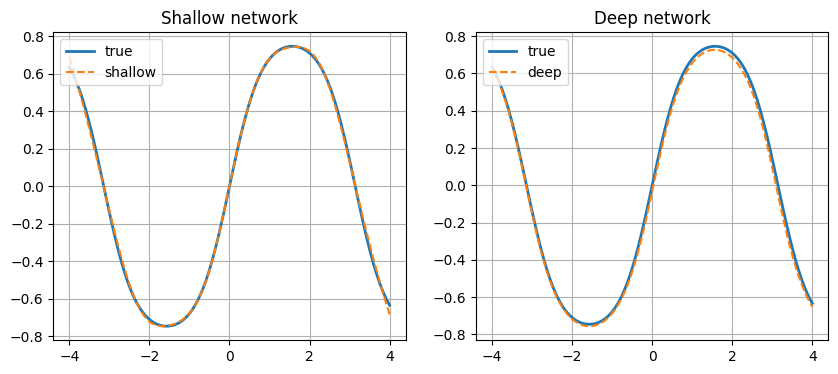

In [6]:
with torch.no_grad():
    y_s = shallow(x_t).numpy()
    y_d = deep(x_t).numpy()

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(x, y, label="true", lw=2)
plt.plot(x, y_s, "--", label="shallow")
plt.title("Shallow network")
plt.legend(); plt.grid()

plt.subplot(1,2,2)
plt.plot(x, y, label="true", lw=2)
plt.plot(x, y_d, "--", label="deep")
plt.title("Deep network")
plt.legend(); plt.grid()

plt.show()

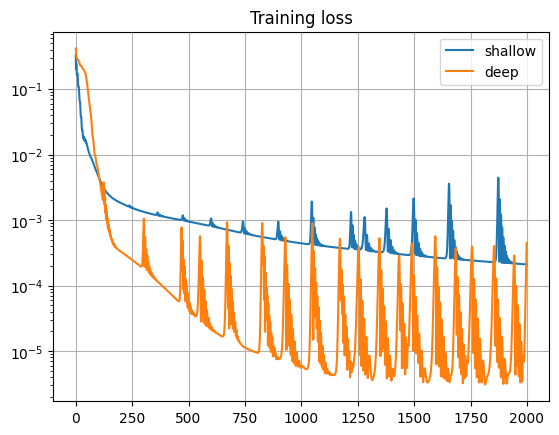

In [7]:
plt.semilogy(loss_s, label="shallow")
plt.semilogy(loss_d, label="deep")
plt.legend(); plt.grid()
plt.title("Training loss")
plt.savefig("shallow_vs_deep_loss.png")
plt.show()

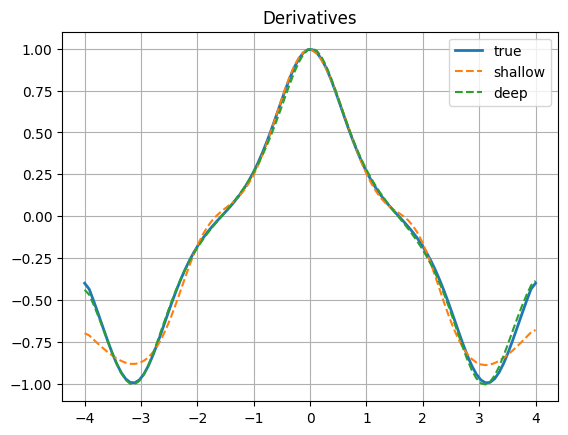

In [8]:
dy_true = np.gradient(y, x)
dy_s = np.gradient(y_s.squeeze(), x)
dy_d = np.gradient(y_d.squeeze(), x)

plt.plot(x, dy_true, label="true", linewidth=2)
plt.plot(x, dy_s, "--", label="shallow")
plt.plot(x, dy_d, "--", label="deep")
plt.title("Derivatives")
plt.legend(); plt.grid()